In [1]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from ROOT import TH1F, TCanvas, RDataFrame
import uproot
%matplotlib inline

Welcome to JupyROOT 6.18/04


In [2]:
def smooth(x, window_len=11, window="hanning"):
    # if x.ndim != 1:
    #     raise ValueError("smooth only accepts 1 dimension arrays.")

    # if x.size < window_len:
    #     raise ValueError("Input vector needs to be bigger than window size.")

    # if window_len < 3:
    #     return x

    if not window in ["flat", "hanning", "hamming", "bartlett", "blackman"]:
        raise ValueError(
            "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
        )

    s = np.r_[x[window_len - 1 : 0 : -1], x, x[-2 : -window_len - 1 : -1]]
    # print(len(s))
    if window == "flat":  # moving average
        w = np.ones(window_len)
    else:
        w = eval("np." + window + "(window_len)")

    y = signal.convolve(s, w / w.sum(), mode="same")

    return y

In [7]:
!ls

muon_decay.ipynb  root_converter.ipynb	single_analysis_test.ipynb


In [8]:
# rel_path = "./Labs/muon_decay/"
# filename = rel_path + "oscil_191216.root"
rel_path = "../../Labs/muon_191219/"
filename = rel_path + "oscill_191218.root"

In [9]:
# df = RDataFrame("tree",filename)

In [10]:
# df_np = RDataFrame("tree",filename).AsNumpy()
# df_np["channel1"].size

In [ ]:
# raw_data = df_np["channel1"][1169]
# n_per_event = raw_data.size()
# timesteps = np.arange(0,n_per_event,1)
# raw_data *= -1.0

In [13]:
df_np = uproot.open(filename)["tree"].array("channel1")
n_events = df_np.size
n_per_event = df_np[0].size
timesteps = np.arange(0,n_per_event,1)


In [14]:
raw_data = np.negative(df_np[1169])

In [18]:
smoothed_data = smooth(raw_data, window_len=51, window='bartlett')
data = np.concatenate((smoothed_data[:n_per_event ,np.newaxis], timesteps[:,np.newaxis]), axis=1)
peak_range = [0.1, data[: ,0].max() ]
peaks, properties = signal.find_peaks(data[: ,0], height=peak_range,distance=250)
results_w = signal.peak_widths(data[: ,0], peaks, rel_height=0.95)


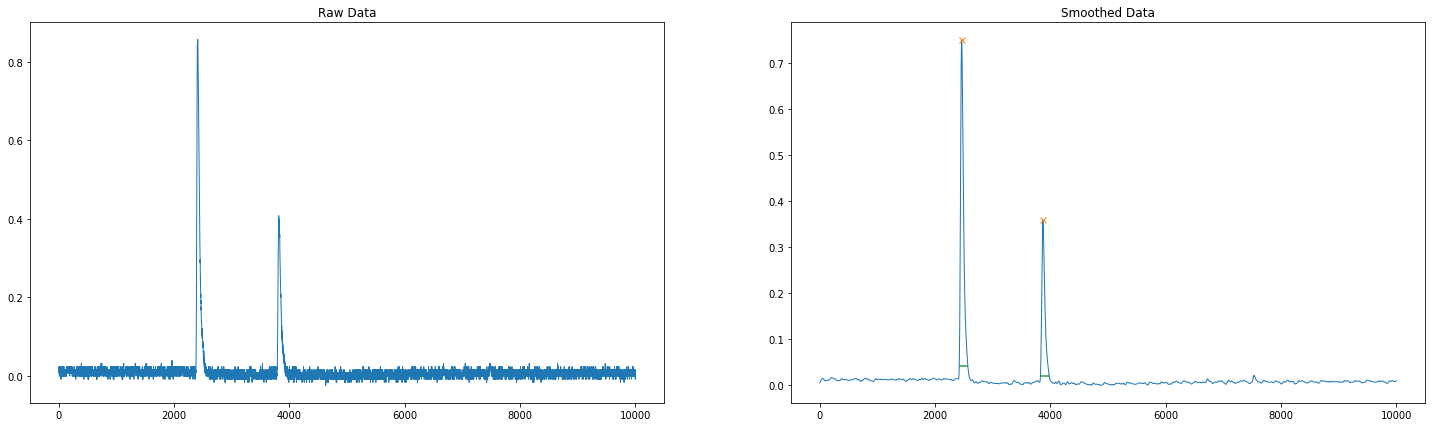

In [19]:
plt.figure(figsize=(25,7))
plt.subplot(121)
plt.plot(timesteps, raw_data, '-', lw=1)
plt.title("Raw Data")
plt.subplot(122)
plt.plot(data[:,1], data[:,0],'-', lw=1)
plt.plot(peaks, data[:,0][peaks], "x")
plt.hlines(*results_w[1:], color="C2")
plt.title("Smoothed Data")
plt.show()

In [20]:
print(f'Peaks width: {results_w[0]}')
for i in range(results_w[1:][0].size):
    print(f'Found peak in range: {results_w[2][i]}, {results_w[3][i]}')
print(f"Found peaks at indices {peaks} with amplitude: {data[peaks,0]}")

Peaks width: [148.39273985 153.5375892 ]
Found peak in range: 2418.9733765584115, 2567.3661164087925
Found peak in range: 3826.72634167654, 3980.263930881049
Found peaks at indices [2460 3870] with amplitude: [0.7516928  0.35912959]


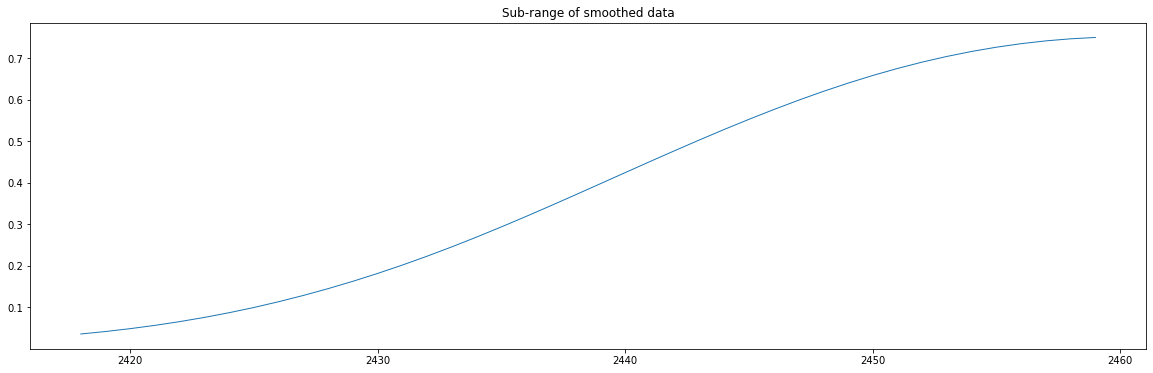

In [21]:
a = int(min(results_w[2]))
ranged_sm_data = data[a:peaks[0]]
plt.figure(figsize=(20,6))
plt.plot(ranged_sm_data[:,1], ranged_sm_data[:,0],'-', lw=1)
plt.title("Sub-range of smoothed data")
plt.show()

3826 3870


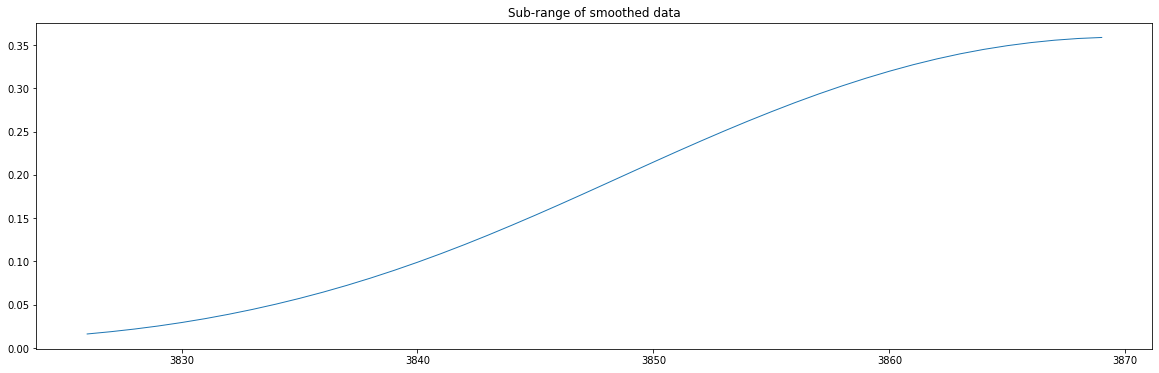

In [22]:
b = int((results_w[2][1]))
print(b,peaks[1])
ranged_sm_data = data[b:peaks[1]]
plt.figure(figsize=(20,6))
plt.plot(ranged_sm_data[:,1], ranged_sm_data[:,0],'-', lw=1)
plt.title("Sub-range of smoothed data")
plt.show()

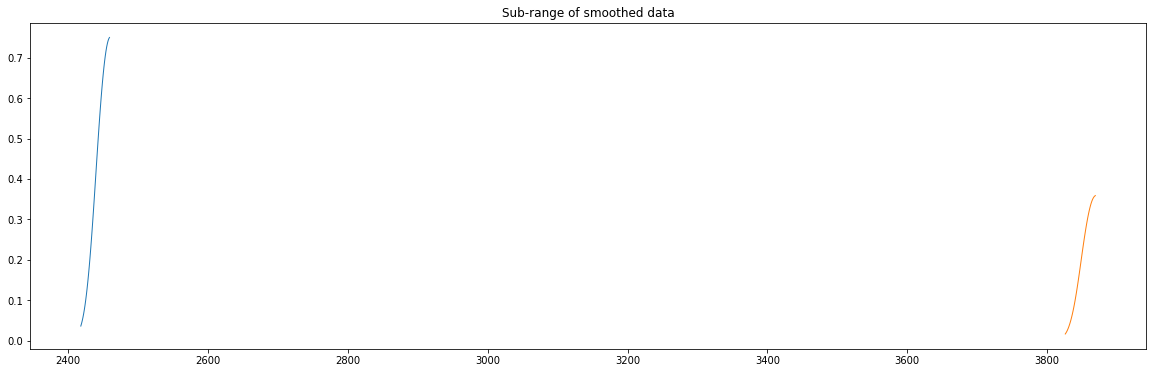

In [23]:
plt.figure(figsize=(20,6))
for min_t, peak in zip(results_w[2], peaks):
    min_t = int(min_t)
    ranged_sm_data = data[min_t:peak]
    plt.plot(ranged_sm_data[:,1], ranged_sm_data[:,0],'-', lw=1)
    plt.title("Sub-range of smoothed data")
plt.show()

In [24]:
import iminuit
import probfit

In [25]:
# We want to speed things up with Cython
%load_ext Cython

In [26]:
%%cython
cimport cython
from libc.math cimport exp
@cython.binding(True) # IMPORTANT: this tells Cython to dump the function signature
def sigmoid(double x, double p0, double p1, double p2, double p3):
    return p0 / (1.0 + exp(-1.0 * p2 * (x - p1) ) ) + p3


# def sigmoid(x, p0, p1, p2, p3):
#     return p0 / (1.0 + np.exp(-1.0 * p2 * (x - p1))) + p3


In [27]:
iminuit.describe(sigmoid)

['x', 'p0', 'p1', 'p2', 'p3']

In [28]:
# from scipy.interpolate import interp1d
# f1 = interp1d(
#                 data[a : peaks[0] + 1, 1],
#                 data[a : peaks[0] + 1, 0],
#             )
# xx = np.linspace(data[a, 1], data[peaks[0], 1], num=200)
# chi2_fit = probfit.Chi2Regression(sigmoid, xx, f1(xx))

In [29]:
chi2_fit = probfit.Chi2Regression(sigmoid, 
            timesteps[a : peaks[0]],
            smoothed_data[a : peaks[0]]
            )
# chi2_fit = probfit.Chi2Regression(
#     sigmoid,
#     data[a : peaks[0], 1],
#     data[a : peaks[0], 0],
# )

minuit = iminuit.Minuit(
                chi2_fit,
                p0=np.max(data[a : peaks[0] + 1, 0]),
                p1=peaks[0],
                p3=np.min(data[a : peaks[0] + 1, 0]),
                limit_p3=(0.001, 1.0),
                pedantic=False,
                print_level=1,
            )
minuit.migrad()
try:
    minuit.hesse()
except Exception as e:
    print(str(e))

------------------------------------------------------------------
| FCN = 0.113                   |     Ncalls=197 (208 total)     |
| EDM = 0.0615 (Goal: 1E-05)    |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------

In [30]:
iminuit.describe(chi2_fit)

['p0', 'p1', 'p2', 'p3']

In [31]:
minuit.migrad()

------------------------------------------------------------------
| FCN = 0.0005805               |     Ncalls=265 (517 total)     |
| EDM = 9.57E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


------------------------------------------------------------------
| FCN = 0.0005805               |     Ncalls=265 (517 total)     |
| EDM = 9.57E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | p0   |    0.8    |    1.0    |            |            |         |         |       |
| 1 | p1   |   2439    |    20     |            |            |         |         |       |
| 2 | p2   |   0.14    |   0.31    |            |            |         |         |       |
| 3 | p3   |   0.004   |   0.636   |            |            |  0.001  |    1    |       |
------------------------------------------------------------------------------------------

In [32]:
minuit.hesse()

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | p0   |    0.8    |    1.0    |            |            |         |         |       |
| 1 | p1   |   2439    |    20     |            |            |         |         |       |
| 2 | p2   |   0.14    |   0.31    |            |            |         |         |       |
| 3 | p3   |   0.004   |   0.653   |            |            |  0.001  |    1    |       |
------------------------------------------------------------------------------------------
--------------------------------
|    |    p0    p1    p2    p3 |
--------------------------------
| p0 |  1.00  0.56 -0.88 -0.66 |
| p1 |  0.56  1.00 -0.48  0.17 |
| p2 | -0.88 -0.48  1.00  0.59 |
| p3 | -0.66  0.17  0.59  1.00 |
--------------------------------


------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | p0   |    0.8    |    1.0    |            |            |         |         |       |
| 1 | p1   |   2439    |    20     |            |            |         |         |       |
| 2 | p2   |   0.14    |   0.31    |            |            |         |         |       |
| 3 | p3   |   0.004   |   0.653   |            |            |  0.001  |    1    |       |
------------------------------------------------------------------------------------------

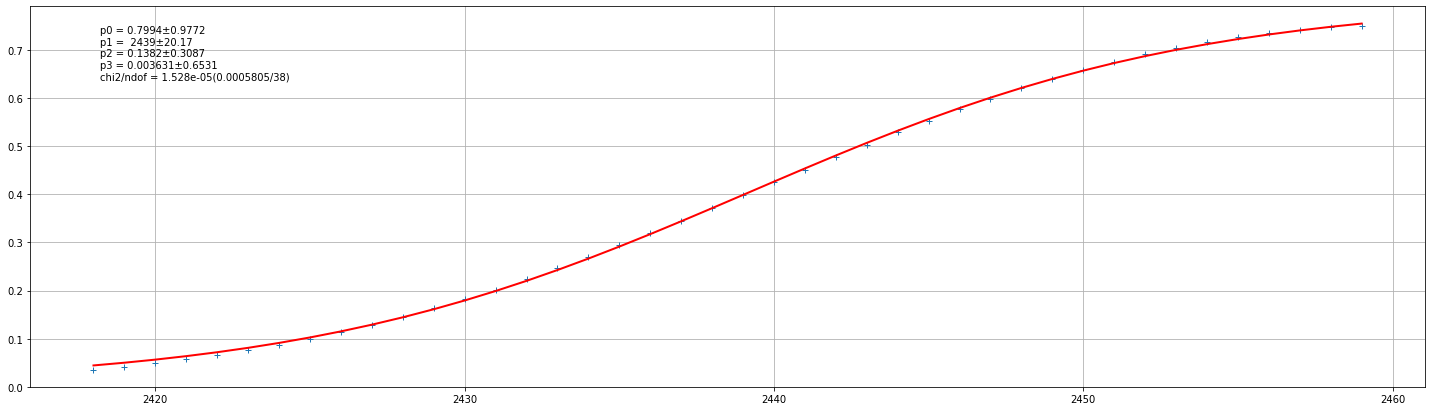

In [33]:
plt.figure(figsize=(25, 7))
chi2_fit.draw(minuit)
plt.show()

In [34]:
minuit.print_fmin()
minuit.print_matrix()

------------------------------------------------------------------
| FCN = 0.0005805               |     Ncalls=265 (557 total)     |
| EDM = 9.57E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
--------------------------------
|    |    p0    p1    p2    p3 |
--------------------------------
| p0 |  1.00  0.56 -0.88 -0.66 |
| p1 |  0.56  1.00 -0.48  0.17 |
| p2 | -0.88 -0.48  1.00  0.59 

In [35]:
print(minuit.values)
print(minuit.errors)

<ValueView of Minuit at 558564fb6870>
  p0: 0.7994417653972943
  p1: 2439.1707861737173
  p2: 0.13820114770999103
  p3: 0.0036312934166215375
<ErrorView of Minuit at 558564fb6870>
  p0: 0.9772045175756855
  p1: 20.17286099056977
  p2: 0.3087165001754158
  p3: 0.653126179770486


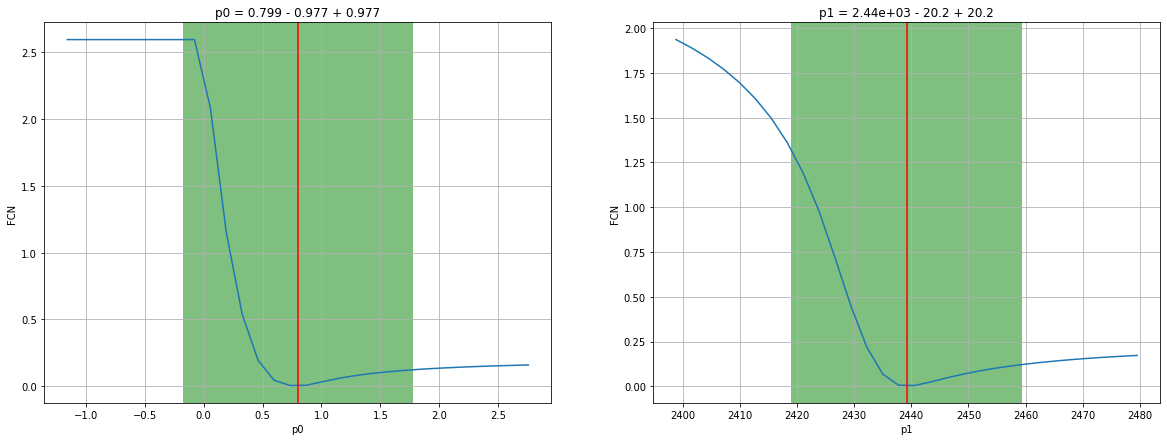

In [36]:
plt.figure(figsize=(20,7))
plt.subplot(121)
minuit.draw_mnprofile('p0')
plt.subplot(122)
minuit.draw_mnprofile('p1')
plt.show()

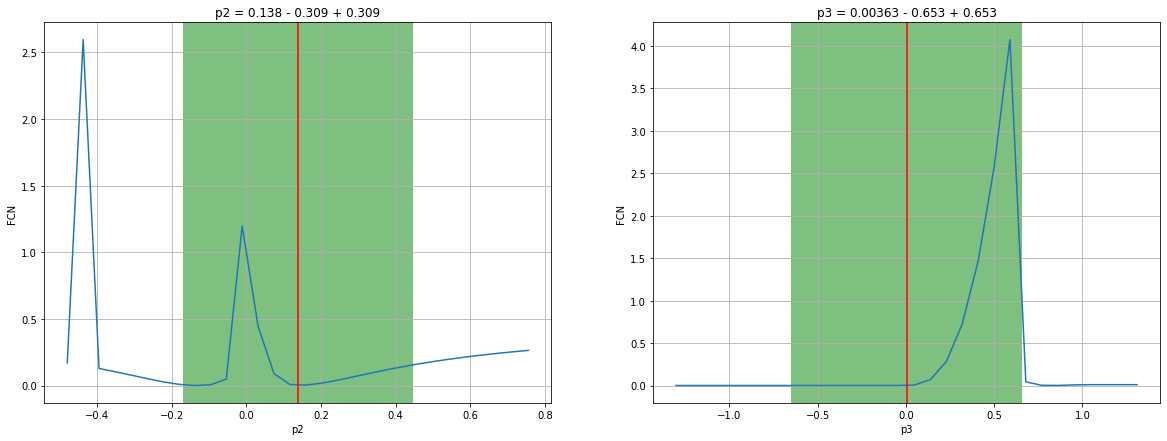

In [37]:
plt.figure(figsize=(20,7))
plt.subplot(121)
minuit.draw_mnprofile('p2')
plt.subplot(122)
minuit.draw_mnprofile('p3')
plt.show()

In [38]:
# for i in range(100):
#     print(df_np["channel1"][0][i], df_np["channel1"][1][i])


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [28]:
# raw_data = df_np["channel1"][0]
# n_per_event = raw_data.size()

In [29]:
# n_per_event

In [39]:
plt.rcParams['figure.figsize'] = (10, 7)


In [40]:
%time
# intial parameters
n_iter = 10000
sz = (n_iter,) # size of array
x = 0# truth value (typo in example at top of p. 13 calls this z)
# z = np.random.normal(x,0.1,size=sz) # observations (normal about x, sigma=0.1)
z = raw_data

Q = 1e-5 # process variance

# allocate space for arrays
xhat=np.zeros(sz)      # a posteri estimate of x
P=np.zeros(sz)         # a posteri error estimate
xhatminus=np.zeros(sz) # a priori estimate of x
Pminus=np.zeros(sz)    # a priori error estimate
K=np.zeros(sz)         # gain or blending factor


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [41]:
%time
# R = 0.1**2 # estimate of measurement variance, change to see effect
R = 0.01**2
# intial guesses
xhat[0] = 0.0
P[0] = 2

for k in range(1,n_iter):
    # time update
    xhatminus[k] = xhat[k-1]
    Pminus[k] = P[k-1]+Q

    # measurement update
    K[k] = Pminus[k]/( Pminus[k]+R )
    xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
    P[k] = (1-K[k])*Pminus[k]

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


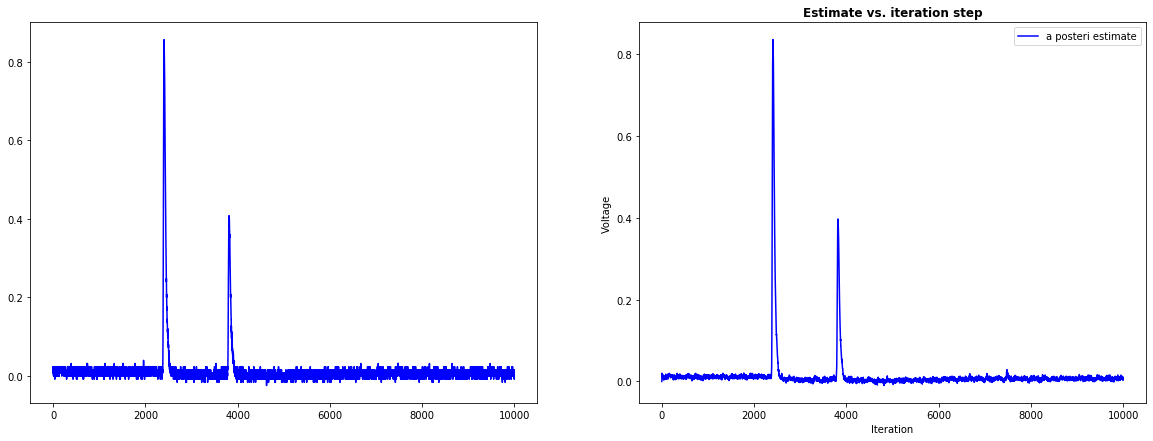

In [42]:
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.plot(z,'b-',label='noisy measurements')
plt.subplot(122)
plt.plot(xhat,'b-',label='a posteri estimate')
# plt.axhline(x,color='g',label='truth value')
plt.legend()
plt.title('Estimate vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Voltage')
plt.show()

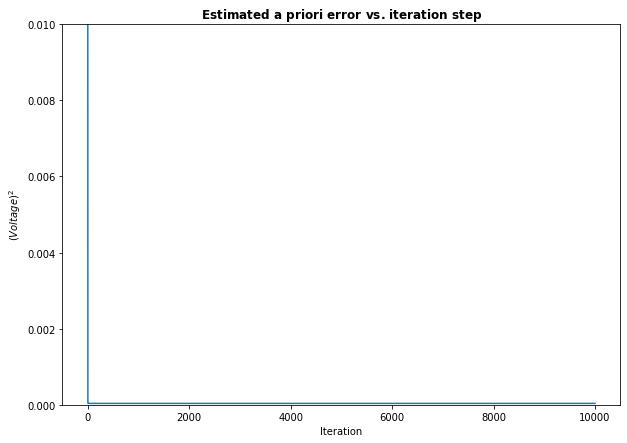

In [43]:
plt.figure()
valid_iter = range(1,n_iter) # Pminus not valid at step 0
plt.plot(valid_iter,Pminus[valid_iter],label='a priori error estimate')
plt.title('Estimated $\it{\mathbf{a \ priori}}$ error vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('$(Voltage)^2$')
plt.setp(plt.gca(),'ylim',[0,.01])
plt.show()

(array([0]),)

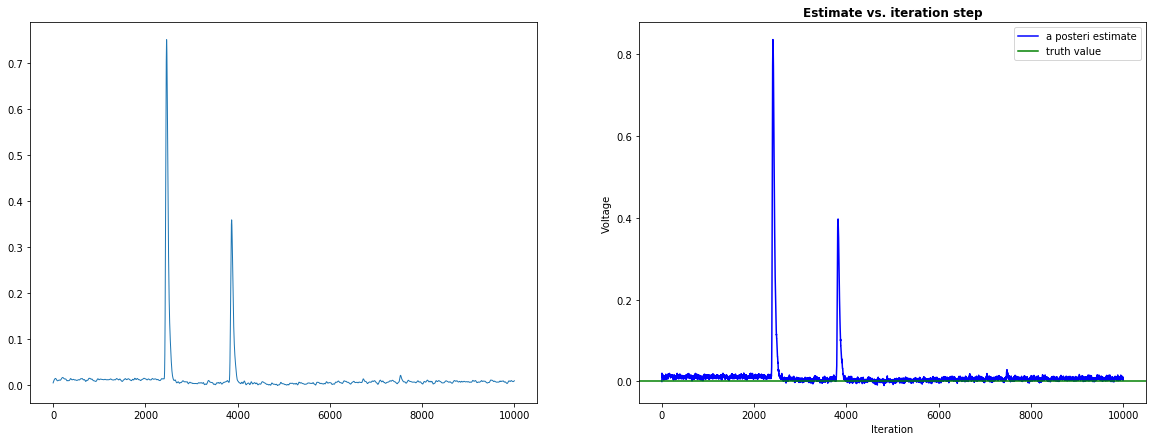

In [44]:
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.plot(data[:,1], data[:,0],'-', lw=1)
plt.subplot(122)
plt.plot(xhat,'b-',label='a posteri estimate')
plt.axhline(x,color='g',label='truth value')
plt.legend()
plt.title('Estimate vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Voltage')
plt.show()

In [45]:
peaks_kl, _ = signal.find_peaks(xhat, height=[0.1,None],distance=250)
results_kl = signal.peak_widths(xhat, peaks_kl, rel_height=0.95)

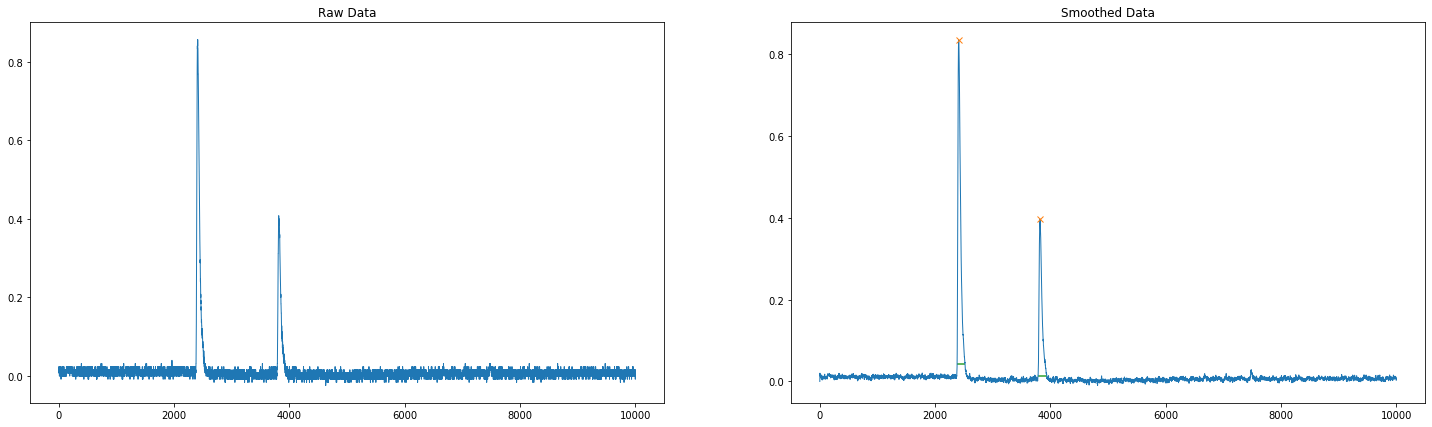

In [48]:
plt.figure(figsize=(25,7))
plt.subplot(121)
plt.plot(timesteps, raw_data, '-', lw=1)
plt.title("Raw Data")
plt.subplot(122)
plt.plot(timesteps, xhat,'-', lw=1)
plt.plot(peaks_kl, xhat[peaks_kl], "x")
plt.hlines(*results_kl[1:], color="C2")
plt.title("Smoothed Data")
plt.show()

In [49]:
print(f'Peaks width: {results_kl[0]}')
for i in range(results_kl[1:][0].size):
    print(f'Found peak in range: {results_kl[2][i]}, {results_kl[3][i]}')
print(f"Found peaks at indices {peaks_kl} with amplitude: {xhat[peaks_kl]}")

Peaks width: [137.75344609 152.99756946]
Found peak in range: 2381.5272675827764, 2519.28071367603
Found peak in range: 3784.4488679070614, 3937.4464373653764
Found peaks at indices [2408 3821] with amplitude: [0.83643174 0.39748328]


In [50]:
np.where(xhat == xhat.max())

(array([2408]),)

In [51]:
xhat.max(), np.max(raw_data)

(0.8364317368477308, 0.856)

In [67]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../../')

In [87]:
from src.python.kalman import kalman

In [53]:
# %%cython -a
# import cython
# import numpy as np
# cimport cython
# # cimport numpy as cnp
# from cython.parallel import prange

# @cython.boundscheck(False)
# @cython.wraparound(False) 
# cpdef kalman_filter(float[:] z, Py_ssize_t size, Py_ssize_t n_iter=10):
#     """
#     Variables:
#     size = size of array,
#     n_iter = number of iterations
#     """
#     Q = 1e-5 # process variance

#     # allocate space for arrays
#     xx = np.zeros(size, dtype=np.float32)
    
#     cdef float[:] xhat = xx      # a posteri estimate of x
#     cdef float[:] P = np.zeros(size ,dtype=np.float32)         # a posteri error estimate
#     cdef float[:] xhatminus = np.zeros(size, dtype=np.float32) # a priori estimate of x
#     cdef float[:] Pminus = np.zeros(size, dtype=np.float32)    # a priori error estimate
#     cdef float[:] K = np.zeros(size, dtype=np.float32)         # gain or blending factor

#     R = 0.01**2 # estimate of measurement variance, change to see effect

#     # intial guesses
#     xhat[0] = 0.0
#     P[0] = 2.0
#     cdef Py_ssize_t k, n_it = n_iter
#     for k in prange(1, n_it, nogil=True):
#         # time update
#         xhatminus[k] = xhat[k-1]
#         Pminus[k] = P[k-1]+Q

#         # measurement update
#         K[k] = Pminus[k]/( Pminus[k]+R )
#         xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
#         P[k] = (1-K[k])*Pminus[k]
    
#     return xx, P


In [69]:
ayy = np.asarray(raw_data)

0.016

In [88]:
%time
lmao = kalman.kalman_filter(ayy, len(ayy), len(ayy))
# lmao, _ = kalman_filter(ayy, len(ayy), len(ayy))

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 22.9 µs


In [91]:
%timeit lmao = kalman.kalman_filter(ayy, len(ayy), len(ayy))

177 µs ± 1.23 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
raw_data

<ROOT.ROOT::VecOps::RVec<float> object at 0x5557d26897d0>

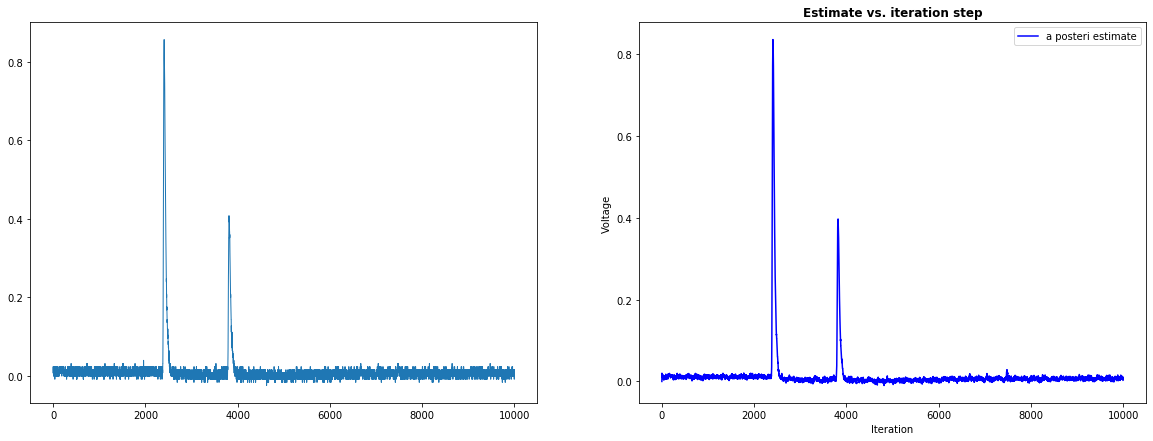

In [92]:
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.plot(ayy,'-', lw=1)
plt.subplot(122)
plt.plot(lmao,'b-',label='a posteri estimate')
# plt.axhline(x,color='g',label='truth value')
plt.legend()
plt.title('Estimate vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Voltage')
plt.show()

In [113]:
ayy.max(), lmao.max()

(0.856, 0.83643174)